In [1]:
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, sim2tra=False)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=3)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs)

Number of images found: 3612
Number of labels found: 3612
Number of unique characters: 1873
Characters present: {'𠬠': 454, '㐌': 388, '浪': 356, '朱': 293, '\U000f047c': 261, '尼': 257, '娘': 254, '𢚸': 248, '㝵': 240, '𦋦': 234, '吏': 230, '拱': 223, '之': 198, '埃': 196, '情': 189, '買': 180, '群': 176, '𠳒': 176, '芇': 173, '麻': 172, '固': 167, '𠇮': 162, '𠓨': 160, '欺': 156, '別': 152, '仙': 151, '花': 146, '爫': 144, '昆': 140, '𡗶': 135, '𠄩': 131, '塘': 130, '時': 129, '冲': 126, '畧': 125, '𦖑': 125, '渚': 125, '如': 125, '𠫾': 122, '旦': 122, '渃': 121, '牢': 116, '払': 114, '呐': 113, '強': 112, '分': 112, '些': 111, '低': 108, '傷': 106, '庄': 106, '咍': 105, '生': 103, '鐄': 103, '𢬣': 102, '\U000f061a': 102, '𧗱': 100, '身': 99, '皮': 99, '浽': 99, '仍': 99, '調': 98, '茹': 96, '饒': 92, '庒': 91, '\U000f0832': 91, '沛': 88, '𣈜': 88, '公': 87, '細': 86, '月': 85, '油': 83, '爲': 83, '戈': 83, '排': 82, '扵': 77, '碎': 77, '㗂': 77, '\U000f02c7': 76, '催': 76, '包': 75, '体': 75, '緣': 72, '女': 70, '𬂙': 70, '𡦂': 69, '它': 69, '意': 69, '耒': 69, '迻'

## Visualize the data

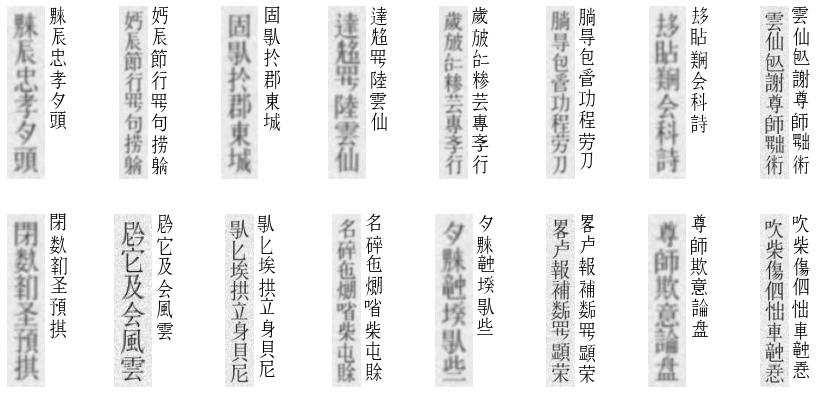

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
from ctc import CTCLayer

In [9]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing the output to the RNN
    x = reshape_for_cnn(x, dim_to_keep=-1)

    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.2,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    return model

In [10]:
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary(line_length=100)

In [11]:
# imagenet_output_layer = 'block4_pool'
# model = build_crnn(imagenet_model, imagenet_output_layer)
model = build_crnn()
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

# Training

In [12]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Data input pipeline

In [13]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [14]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Callbacks

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [16]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [17]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
    )

In [18]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

Start training for Fold 01:
Epoch 1/100
204/204 [==============================] - 15s 45ms/step - loss: 49.8308 - val_loss: 56.3442 - lr: 2.0000e-04
Epoch 2/100
204/204 [==============================] - 6s 31ms/step - loss: 39.3543 - val_loss: 35.5974 - lr: 2.0000e-04
Epoch 3/100
204/204 [==============================] - 6s 31ms/step - loss: 20.5059 - val_loss: 18.2190 - lr: 2.0000e-04
Epoch 4/100
204/204 [==============================] - 6s 31ms/step - loss: 9.8718 - val_loss: 10.9559 - lr: 2.0000e-04
Epoch 5/100
204/204 [==============================] - 6s 31ms/step - loss: 4.9880 - val_loss: 7.1000 - lr: 2.0000e-04
Epoch 6/100
204/204 [==============================] - 6s 31ms/step - loss: 2.5927 - val_loss: 5.2443 - lr: 2.0000e-04
Epoch 7/100
204/204 [==============================] - 6s 31ms/step - loss: 1.3551 - val_loss: 4.5669 - lr: 2.0000e-04
Epoch 8/100
204/204 [==============================] - 6s 31ms/step - loss: 0.7336 - val_loss: 3.4613 - lr: 2.0000e-04
Epoch 9/100


204/204 [==============================] - 6s 31ms/step - loss: 0.0133 - val_loss: 1.9272 - lr: 1.2500e-05
Epoch 38/100
202/204 [============================>.] - ETA: 0s - loss: 0.0131
Epoch 38: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
 - Mean edit distance: 1.3788043
204/204 [==============================] - 6s 31ms/step - loss: 0.0131 - val_loss: 1.9379 - lr: 1.2500e-05
Epoch 39/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0130 - val_loss: 1.9235 - lr: 6.2500e-06
Epoch 40/100
203/204 [============================>.] - ETA: 0s - loss: 0.0128
Epoch 40: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
 - Mean edit distance: 1.3815217
204/204 [==============================] - 6s 31ms/step - loss: 0.0128 - val_loss: 1.9181 - lr: 6.2500e-06
Epoch 41/100
204/204 [==============================] - 7s 32ms/step - loss: 0.0128 - val_loss: 1.9305 - lr: 3.1250e-06
Epoch 42/100
203/204 [============================>.] - ETA: 0s

204/204 [==============================] - 6s 31ms/step - loss: 0.0504 - val_loss: 2.4093 - lr: 2.0000e-04
Epoch 18/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0437 - val_loss: 2.3969 - lr: 2.0000e-04
Epoch 19/100
204/204 [==============================] - 6s 32ms/step - loss: 0.0380 - val_loss: 2.3894 - lr: 2.0000e-04
Epoch 20/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0332 - val_loss: 2.3900 - lr: 2.0000e-04
Epoch 21/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0292 - val_loss: 2.3432 - lr: 2.0000e-04
Epoch 22/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0259 - val_loss: 2.3861 - lr: 2.0000e-04
Epoch 23/100
204/204 [==============================] - 7s 32ms/step - loss: 0.0231 - val_loss: 2.3198 - lr: 2.0000e-04
Epoch 24/100
204/204 [==============================] - 7s 32ms/step - loss: 0.0206 - val_loss: 2.3050 - lr: 2.0000e-04
Epoch 25/100
204/204 [==============================]

Epoch 53/100
204/204 [==============================] - 7s 33ms/step - loss: 0.0080 - val_loss: 2.2338 - lr: 3.1250e-06
Epoch 54/100
204/204 [==============================] - 6s 32ms/step - loss: 0.0079 - val_loss: 2.2455 - lr: 3.1250e-06
Epoch 55/100
203/204 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 55: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
 - Mean edit distance: 1.4344808
204/204 [==============================] - 6s 31ms/step - loss: 0.0079 - val_loss: 2.2442 - lr: 3.1250e-06
Epoch 56/100
204/204 [==============================] - 7s 32ms/step - loss: 0.0079 - val_loss: 2.2722 - lr: 1.5625e-06
Epoch 57/100
204/204 [==============================] - ETA: 0s - loss: 0.0078
Epoch 57: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
 - Mean edit distance: 1.4263285
204/204 [==============================] - 7s 32ms/step - loss: 0.0078 - val_loss: 2.2600 - lr: 1.5625e-06
Epoch 58/100
203/204 [============================

Epoch 31/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0146 - val_loss: 2.5724 - lr: 5.0000e-05
Epoch 32/100
204/204 [==============================] - 6s 32ms/step - loss: 0.0141 - val_loss: 2.5933 - lr: 5.0000e-05
Epoch 33/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0136 - val_loss: 2.5656 - lr: 5.0000e-05
Epoch 34/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0131 - val_loss: 2.5617 - lr: 5.0000e-05
Epoch 35/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0126 - val_loss: 2.5628 - lr: 5.0000e-05
Epoch 36/100
203/204 [============================>.] - ETA: 0s - loss: 0.0121
Epoch 36: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.6310387
204/204 [==============================] - 6s 32ms/step - loss: 0.0121 - val_loss: 2.5619 - lr: 5.0000e-05
Epoch 37/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0120 - val_loss: 2.5473 -

Epoch 21/100
202/204 [============================>.] - ETA: 0s - loss: 0.0304
Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.4679952
204/204 [==============================] - 6s 31ms/step - loss: 0.0304 - val_loss: 2.1300 - lr: 2.0000e-04
Epoch 22/100
204/204 [==============================] - 7s 32ms/step - loss: 0.0278 - val_loss: 2.0679 - lr: 1.0000e-04
Epoch 23/100
204/204 [==============================] - 6s 32ms/step - loss: 0.0258 - val_loss: 2.0492 - lr: 1.0000e-04
Epoch 24/100
204/204 [==============================] - 6s 32ms/step - loss: 0.0242 - val_loss: 2.0587 - lr: 1.0000e-04
Epoch 25/100
202/204 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 25: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.4522947
204/204 [==============================] - 6s 32ms/step - loss: 0.0226 - val_loss: 2.0576 - lr: 1.0000e-04
Epoch 26/100
204/204 [==========================

204/204 [==============================] - 7s 32ms/step - loss: 5.8231 - val_loss: 21.2995 - lr: 2.0000e-04
Epoch 10/100
203/204 [============================>.] - ETA: 0s - loss: 3.7871 - Mean edit distance: 4.7439613
Restored weights from the end of epoch: 5
204/204 [==============================] - 7s 32ms/step - loss: 3.7871 - val_loss: 19.4877 - lr: 2.0000e-04
Epoch 10: early stopping
Finish training for Fold 06

Start training for Fold 07:
Epoch 1/100
204/204 [==============================] - 13s 41ms/step - loss: 50.2454 - val_loss: 54.9503 - lr: 2.0000e-04
Epoch 2/100
204/204 [==============================] - 6s 32ms/step - loss: 43.2335 - val_loss: 45.0871 - lr: 2.0000e-04
Epoch 3/100
204/204 [==============================] - 7s 32ms/step - loss: 36.9791 - val_loss: 40.1965 - lr: 2.0000e-04
Epoch 4/100
204/204 [==============================] - 7s 32ms/step - loss: 29.6881 - val_loss: 33.3096 - lr: 2.0000e-04
Epoch 5/100
204/204 [==============================] - 6s 32ms/s

 - Mean edit distance: 1.5902778
204/204 [==============================] - 6s 32ms/step - loss: 0.0200 - val_loss: 2.8738 - lr: 2.0000e-04
Epoch 26/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0185 - val_loss: 2.8222 - lr: 1.0000e-04
Epoch 27/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0174 - val_loss: 2.8276 - lr: 1.0000e-04
Epoch 28/100
202/204 [============================>.] - ETA: 0s - loss: 0.0164
Epoch 28: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.5685387
204/204 [==============================] - 6s 31ms/step - loss: 0.0164 - val_loss: 2.8275 - lr: 1.0000e-04
Epoch 29/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0159 - val_loss: 2.7816 - lr: 5.0000e-05
Epoch 30/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0154 - val_loss: 2.7857 - lr: 5.0000e-05
Epoch 31/100
204/204 [==============================] - 6s 31ms/step - loss: 0.0148 

204/204 [==============================] - 6s 32ms/step - loss: 2.9713 - val_loss: 18.5925 - lr: 2.0000e-04
Epoch 11/100
203/204 [============================>.] - ETA: 0s - loss: 1.9065 - Mean edit distance: 4.480676
Restored weights from the end of epoch: 6
204/204 [==============================] - 7s 32ms/step - loss: 1.9064 - val_loss: 16.2028 - lr: 2.0000e-04
Epoch 11: early stopping
Finish training for Fold 09

Start training for Fold 10:
Epoch 1/100
204/204 [==============================] - 13s 41ms/step - loss: 49.7985 - val_loss: 54.7506 - lr: 2.0000e-04
Epoch 2/100
204/204 [==============================] - 6s 31ms/step - loss: 42.1259 - val_loss: 46.7178 - lr: 2.0000e-04
Epoch 3/100
204/204 [==============================] - 6s 31ms/step - loss: 35.2766 - val_loss: 40.5939 - lr: 2.0000e-04
Epoch 4/100
204/204 [==============================] - 6s 31ms/step - loss: 27.6329 - val_loss: 35.6420 - lr: 2.0000e-04
Epoch 5/100
204/204 [==============================] - 6s 32ms/st

## Get the best CRNN model and its results

In [19]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_edist_log, 
    best_history,
    best_model,
    best_fold_idx, 
    best_loss
) = get_best_fold(valid_datasets, best_epochs, edist_logs, histories, models)

Fold 01 - Mean edit distance: 1.3815217018127441
23/23 [==============================] - 0s 14ms/step - loss: 1.9181
Fold 02 - Mean edit distance: 6.3565216064453125
23/23 [==============================] - 0s 14ms/step - loss: 28.4620
Fold 03 - Mean edit distance: 1.4344807863235474
23/23 [==============================] - 0s 13ms/step - loss: 2.2338
Fold 04 - Mean edit distance: 1.5990338325500488
23/23 [==============================] - 0s 14ms/step - loss: 2.5054
Fold 05 - Mean edit distance: 1.457729458808899
23/23 [==============================] - 0s 14ms/step - loss: 1.9460
Fold 06 - Mean edit distance: 6.691123008728027
23/23 [==============================] - 0s 13ms/step - loss: 31.1890
Fold 07 - Mean edit distance: 6.898550987243652
23/23 [==============================] - 0s 13ms/step - loss: 31.7962
Fold 08 - Mean edit distance: 1.5467995405197144
23/23 [==============================] - 0s 13ms/step - loss: 2.7390
Fold 09 - Mean edit distance: 5.484299182891846
23/23 [=

Fold 0 has the best loss: 1.9180607795715332


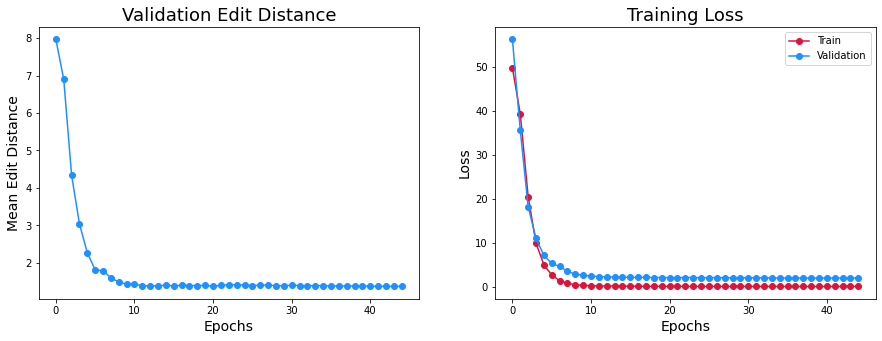

In [20]:
print('Fold', best_fold_idx, 'has the best loss:', best_loss)
plot_training_results(best_history, best_edist_log, 'CRNN.png')
best_model.save('CRNN.h5')

# Inference

In [21]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions

## Reload the model

In [22]:
reloaded_model = load_model('CRNN.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_1"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

## On test dataset

Batch 1: ['固𠊛扵郡東城', '𠫾䀡\U000f0609会科詩', '雲仙𠓨謝尊師𦋦𧗱', '椿萱歲鶴㐌高', '𡢐昆𠄩𡦂科期', '為匕淡娄裊塘群賖', '呌蹺𨅸吏𤑟𢈱分戈', '枚𠊛朱塊劳刀貝尼', '欺空𠇮吏墫𠇮𠓨𡎟', '畧掑𭛣与在眉', '娄\U000f047c𦊚費𡲤散', '䜹浪碎寔𠊛𬆄', '嗔迻𠬠物底扲爫信', '云仙苦浽爫清', '月娥應㗂吀侯', '云仙和吏𠬠排𢭂𦋦']

Batch 2: ['叙情一幅和\U00030654來', '傕匕㛪唉金連', '𠖰車朱姉戈沔河溪', '𪀄呌猿唿𦊚皮渃𡽫', '故牢𢧚浽昆𠫾𠬠𠇮', '𠰺浪昆唉暫安府鐄', '畧𡢐\U000f086b拱庒迡', '𡀯娘𡢐唉群𥹰', '𠇮高路匕異奇叱凶', '𢜠浪𫢩𧡊昆些', '闭𥹰畑册固功', '昆油𨀈鄧湯𩄲', '\U000f084e嗔㐌産固𦀊絲紅', '双親吲保𣃣衝', '悶卢役渃沛筭役茄', '大科嗔及小科卢夷']

Batch 3: ['彩鸾倍且𨆢蹎', '箕\U000f047c茦𦲿𨢇橷', '\U000f086b冲經史固全\U000f0803庒', '舘浪咭𭛣尋抛', '仙浪翁舘渚唭', '歆油固杜拱空𢧚耒', '丿\U000f0993𠫾﨤信茄\U000f0742书', '冲𠇮空𦑃空𡆫', '𬁖移物𠲝群夷麻蒙', '埃咍斫鬼謀神', '\U000f0629塵埃拱\U000f0629塵如埃', '𠫾𣃣𠬠淡賖匕', '當欺过対咹𠓨拱𩛂', '云仙䀡𧡊卞𪟽冲𢚸', '𢪀隊干吏𠼦麻隊干', '嵬匕𠬠𬌓𢚸崙']



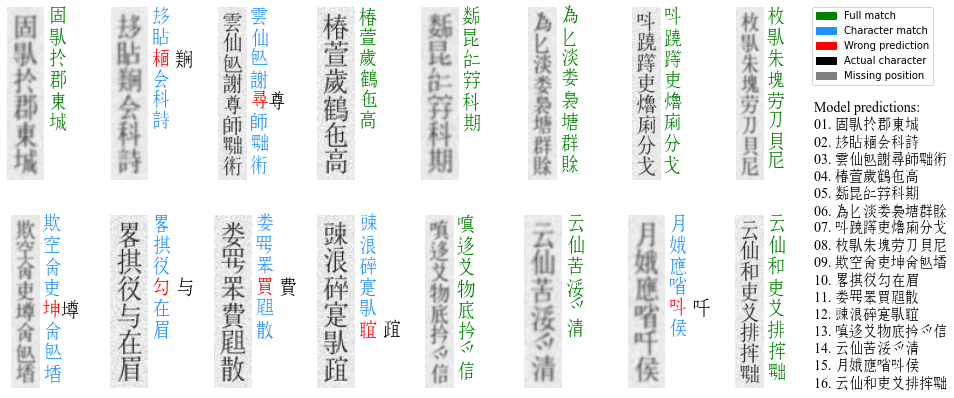

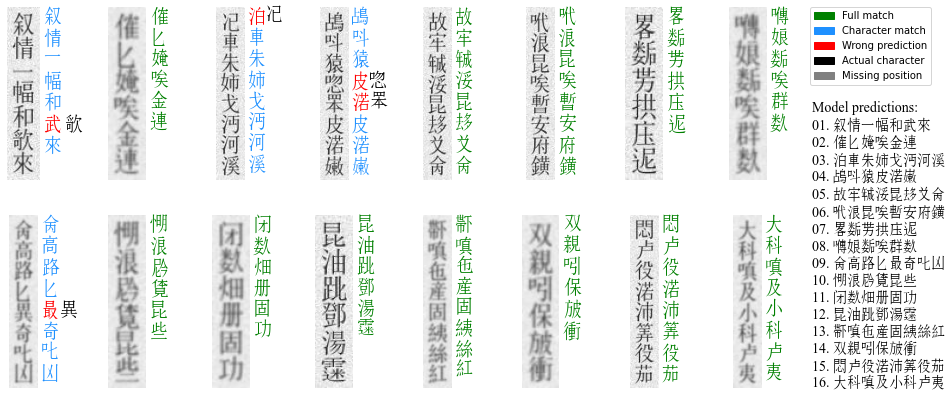

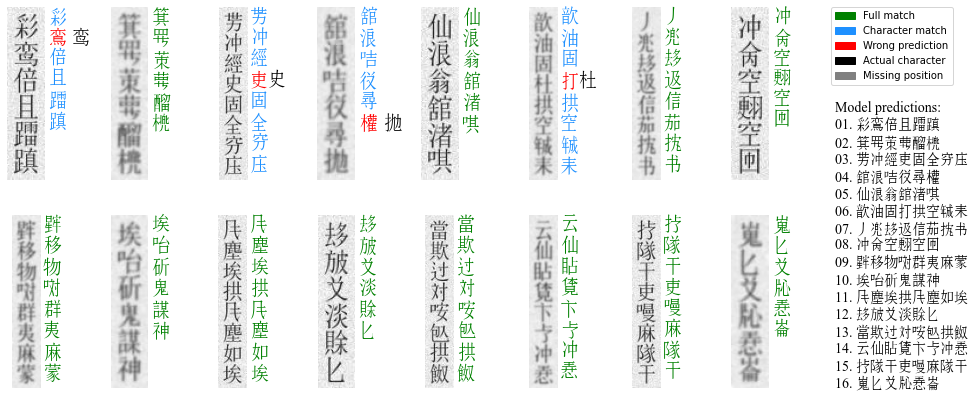

In [23]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, batch in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels_in_batch = []
    
    for label in batch['label']:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        labels_in_batch.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch['image'])
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels_in_batch, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {labels_in_batch}\n')

## On random image

In [24]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)

Predicted text: 大越史愈全書


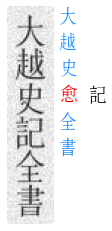

In [25]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))